In [1]:
# Clone the SPAI repository
!git clone https://github.com/mever-team/spai.git

# Install required Python packages
!pip install -r spai/requirements.txt

# (Optional) Install NVIDIA Apex for training, if needed (not required for inference/demo)
# !pip install -U git+https://github.com/NVIDIA/apex.git

# Change working directory to the repo
%cd spai


fatal: destination path 'spai' already exists and is not an empty directory.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7ew5r706
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7ew5r706
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
/content/spai


Saving image-from-rawpixel-id-6029763-original.jpg to image-from-rawpixel-id-6029763-original (3).jpg


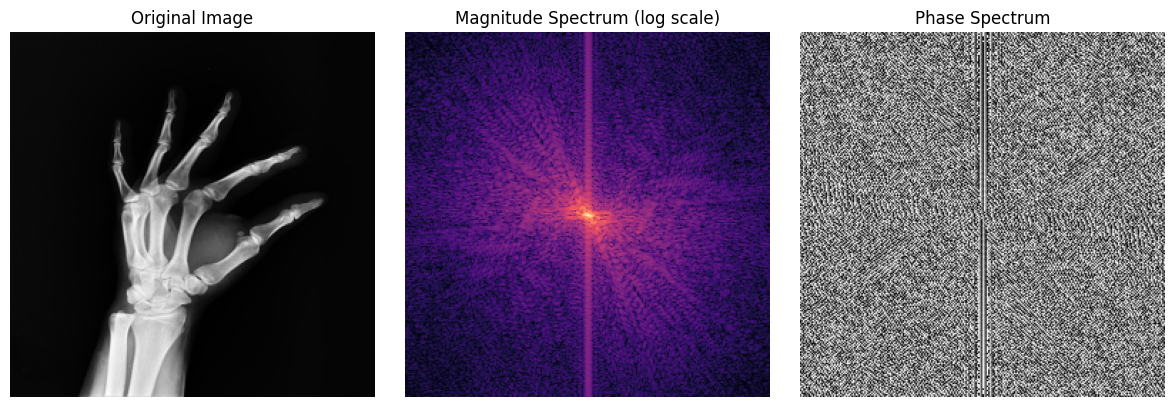

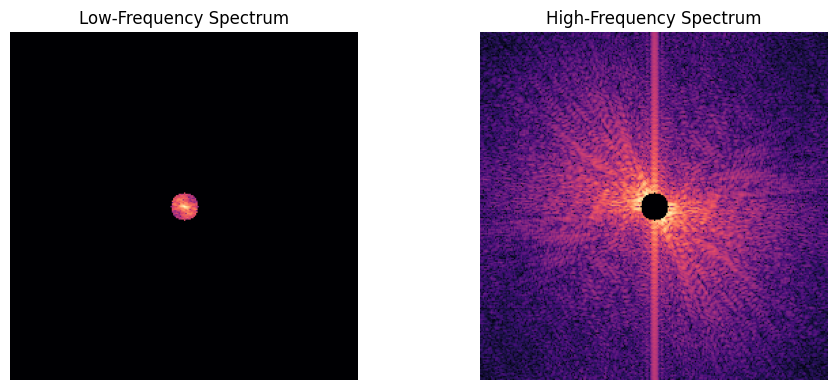

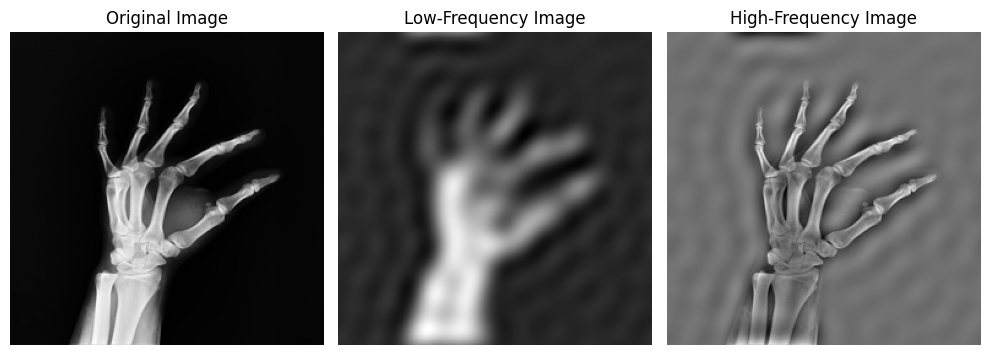

In [8]:
# Step 1: Upload an image
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()
filename = next(iter(uploaded))

# Step 2: Open, convert to grayscale, resize to 256x256
img = Image.open(filename).convert('L')
img = img.resize((256, 256))
img_array = np.array(img).astype(np.float32) / 255.0  # Normalize to [0,1]

# Step 3: Compute FFT and shift zero-frequency to center
F = np.fft.fft2(img_array)
F_shifted = np.fft.fftshift(F)
magnitude = np.log1p(np.abs(F_shifted))  # log(1 + |F|), good for display
phase = np.angle(F_shifted)

# Step 4: Visualize original image, magnitude, and phase spectrum
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_array, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(magnitude, cmap='magma')
plt.title("Magnitude Spectrum (log scale)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(phase, cmap='gray')
plt.title("Phase Spectrum")
plt.axis('off')
plt.tight_layout()
plt.show()

# Step 5: Frequency Masking Setup
H, W = img_array.shape
cH, cW = H // 2, W // 2
r = 10  # Mask radius for low frequencies

# Create low-pass and high-pass masks
Y, X = np.ogrid[:H, :W]
distance = np.sqrt((Y - cH)**2 + (X - cW)**2)
low_mask = (distance <= r).astype(np.float32)
high_mask = 1.0 - low_mask

# Apply masks
F_low = F_shifted * low_mask
F_high = F_shifted * high_mask

# Inverse FFT to get spatial-domain images
x_l = np.real(np.fft.ifft2(np.fft.ifftshift(F_low)))
x_h = np.real(np.fft.ifft2(np.fft.ifftshift(F_high)))

# Step 6: Visualize masked spectra
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log1p(np.abs(F_low)), cmap='magma')
plt.title("Low-Frequency Spectrum")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.log1p(np.abs(F_high)), cmap='magma')
plt.title("High-Frequency Spectrum")
plt.axis('off')
plt.tight_layout()
plt.show()

# Step 7: Visualize reconstructed images
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_array, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(x_l, cmap='gray')
plt.title("Low-Frequency Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(x_h, cmap='gray')
plt.title("High-Frequency Image")
plt.axis('off')
plt.tight_layout()
plt.show()
